In [1]:
import pandas as pd
import json
import numpy as np
from pandas.io.json import json_normalize
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

from matplotlib.path import Path

from scipy.spatial import distance



## Read one game's moments and events dataset

In [2]:
moments_df = pd.read_json("0021500001.json") 

## Create dataframe for movement data appended with events

In [3]:
with open('0021500001.json') as data_file:    
    data = json.load(data_file)
json_normalize(data['events'])

,eventId,home.abbreviation,home.name,home.players,home.teamid,moments,visitor.abbreviation,visitor.name,visitor.players,visitor.teamid
0,1,ATL,Atlanta Hawks,"[{u'playerid': 2594, u'lastname': u'Korver', u...",1610612737,"[[1, 1445991110020, 720.0, 24.0, None, [[-1, -...",DET,Detroit Pistons,"[{u'playerid': 2581, u'lastname': u'Blake', u'...",1610612765
1,2,ATL,Atlanta Hawks,"[{u'playerid': 2594, u'lastname': u'Korver', u...",1610612737,"[[1, 1445991114020, 717.41, 21.4, None, [[-1, ...",DET,Detroit Pistons,"[{u'playerid': 2581, u'lastname': u'Blake', u'...",1610612765
2,3,ATL,Atlanta Hawks,"[{u'playerid': 2594, u'lastname': u'Korver', u...",1610612737,"[[1, 1445991114020, 717.41, 21.4, None, [[-1, ...",DET,Detroit Pistons,"[{u'playerid': 2581, u'lastname': u'Blake', u'...",1610612765
3,4,ATL,Atlanta Hawks,"[{u'playerid': 2594, u'lastname': u'Korver', u...",1610612737,"[[1, 1445991129019, 702.12, 6.48, None, [[-1, ...",DET,Detroit Pistons,"[{u'playerid': 2581, u'lastname': u'Blake', u'...",1610612765
4,5,ATL,Atlanta Hawks,"[{u'playerid': 2594, u'lastname': u'Korver', u...",1610612737,"[[1, 1445991141099, 697.0, 24.0, None, [[-1, -...",DET,Detroit Pistons,"[{u'playerid': 2581, u'lastname': u'Blake', u'...",1610612765
5,6,ATL,Atlanta Hawks,"[{u'playerid': 2594, u'lastname': u'Korver', u...",1610612737,"[[1, 1445991160018, 683.22, 9.41, None, [[-1, ...",DET,Detroit Pistons,"[{u'playerid': 2581, u'lastname': u'Blake', u'...",1610612765
6,7,ATL,Atlanta Hawks,"[{u'playerid': 2594, u'lastname': u'Korver', u...",1610612737,"[[1, 1445991181018, 662.29, 7.4, None, [[-1, -...",DET,Detroit Pistons,"[{u'playerid': 2581, u'lastname': u'Blake', u'...",1610612765
7,8,ATL,Atlanta Hawks,"[{u'playerid': 2594, u'lastname': u'Korver', u...",1610612737,"[[1, 1445991196017, 647.34, 13.3, None, [[-1, ...",DET,Detroit Pistons,"[{u'playerid': 2581, u'lastname': u'Blake', u'...",1610612765
8,9,ATL,Atlanta Hawks,"[{u'playerid': 2594, u'lastname': u'Korver', u...",1610612737,"[[1, 1445991196017, 647.34, 13.3, None, [[-1, ...",DET,Detroit Pistons,"[{u'playerid': 2581, u'lastname': u'Blake', u'...",1610612765
9,10,ATL,Atlanta Hawks,"[{u'playerid': 2594, u'lastname': u'Korver', u...",1610612737,"[[1, 1445991217016, 626.41, 24.0, None, [[-1, ...",DET,Detroit Pistons,"[{u'playerid': 2581, u'lastname': u'Blake', u'...",1610612765


## Helper method to grab moments for a eventNum (possession)

In [4]:
def MomentsfromEventNum(eventsData, eventNum):
    return eventsData['events'][eventNum]["moments"]

## In array of events , select 23rd row "possession" to get all moments data

In [5]:
data['events'][23]

{u'eventId': u'28',
 u'home': {u'abbreviation': u'ATL',
  u'name': u'Atlanta Hawks',
  u'players': [{u'firstname': u'Kyle',
    u'jersey': u'26',
    u'lastname': u'Korver',
    u'playerid': 2594,
    u'position': u'G'},
   {u'firstname': u'Thabo',
    u'jersey': u'25',
    u'lastname': u'Sefolosha',
    u'playerid': 200757,
    u'position': u'G-F'},
   {u'firstname': u'Paul',
    u'jersey': u'4',
    u'lastname': u'Millsap',
    u'playerid': 200794,
    u'position': u'F'},
   {u'firstname': u'Al',
    u'jersey': u'15',
    u'lastname': u'Horford',
    u'playerid': 201143,
    u'position': u'F-C'},
   {u'firstname': u'Tiago',
    u'jersey': u'11',
    u'lastname': u'Splitter',
    u'playerid': 201168,
    u'position': u'F-C'},
   {u'firstname': u'Jeff',
    u'jersey': u'0',
    u'lastname': u'Teague',
    u'playerid': 201952,
    u'position': u'G'},
   {u'firstname': u'Shelvin',
    u'jersey': u'8',
    u'lastname': u'Mack',
    u'playerid': 202714,
    u'position': u'G'},
   {u'firstn

In [6]:
def GameTimetoSeconds(time):
    mins, secs = time.split(":")
    timeSecs = int(mins)*60+int(secs)
    print(timeSecs)
    return timeSecs

In [7]:
gameInSeconds = GameTimetoSeconds("9:45")

585


In [8]:
def SecsToGameTime(time):
    mins=(int(time)/60)
    secs=int(time)%60
    print (str(mins)+":"+str(secs))

In [9]:
SecsToGameTime(555.15)

9:15


### Given the game time (12:00) and eventNumber from the Play-by-play data for a recorded event, this method returns the correct eventNumber from the SportsVU data since they actually dont matchup.  This method converts the gametime into seconds (720s = 12:00) which is formatted in SportsVU.  It traverses up and down events until the gametime is within a selected eventNumber.

In [12]:
def findCorrectMomentData(rawSportVUData, quarterPBP, gametimePBP, approxEventNumPBP):
    print("Finding correctSportVU eventNum gameid:"+rawSportVUData['gameid'])

    found = False;
    moments = None
    #convert gametimePBP (12:00) to seconds (720)
    gameInSeconds = GameTimetoSeconds(gametimePBP)
    while (found == False):
        moments = MomentsfromEventNum(rawSportVUData, approxEventNumPBP)
        quarterSportVU = int(moments[0][0])
        print("quarter:"+ str(quarterSportVU))
        print("PBP gameclock:"+str(gameInSeconds)+" SportsVU moment clock:"+str(moments[0][2]))
        
        #check whether this EventNum moment is the correct time frame of the play from Play-by-play
        if(quarterPBP < quarterSportVU):
            approxEventNumPBP -= 1
        elif(quarterPBP > quarterSportVU):    
            approxEventNumPBP  += 1
        elif(int(moments[0][2]) > gameInSeconds and int(moments[len(moments)-1][2]) < gameInSeconds):
            found=True
        elif(moments[0][2] < gameInSeconds):
            approxEventNumPBP -= 1
        elif(moments[len(moments)-1][2] > gameInSeconds):
        # look ahead 1 event 
            approxEventNumPBP += 1
        else:
            return "error"
    print("extracted event num "+ str(approxEventNumPBP))
    return approxEventNumPBP

## correctEventNum=findCorrectMomentData(data,2,"7:06",172)

In [14]:
moments = MomentsfromEventNum(data,172)

In [18]:
data['events'][164]["moments"]

[]

## Identify Moment of CATCH

1.  //sort events moment data from end time to beginning (reverse order)
timeballReceived, locationballReceived = getReceive (recieverID, List[Moments]) 

Each moment is taken every .25s, so the FIRST 8 moments (8 *.25 = 2 seconds) when the receiverID and ball are within (dist <= 1 ft), is when the ball was the moment before the ball was released.

reset numCount = 0;

Starting from this time, continue iterating through moments. If dist from receiver and ball >=1 ft, then this is time the ball was caught.

***separate calculation to check when the ball dist less than 1 ft for another teammate to determine if it was a pass in a certain amount of time (counted numCount)****

2.  Find "latest" instance when   distFrom ( Moment.Positions[0].x,Moment.Position[0].y , Moment.Position[ ??=playerID ].x , Moment.Position[ ??=playerID].y) <= 1ft )

   return the timemilis ,  position[0].x , position[0].y


In [169]:
 def getCatchEventDetails(receiverID, passerID, gametimePBP, moments):
    momentsReversed = moments[::-1]

    index=0
    found = False
    gameInSeconds = GameTimetoSeconds(gametimePBP)
    print("num of moments: "+str(len(momentsReversed)))
    while (found == False):
        if(int(momentsReversed[index][2]) >=  gameInSeconds):
            found=True
        elif(int(momentsReversed[index][2]< gameInSeconds)):
            index += 1
        else:
            return "ERROR"
    
    print("starting at time: "+ str(momentsReversed[index][2]))
    
    #Found the index of the approx start of the event
    numCounts=0
    for i in range(index,len(momentsReversed)):
        if numCounts >= 3:
            timeBallReleased = momentsReversed[i][2]
            indexBallReleased = i
            break
        else:
            ball = momentsReversed[i][5][0]
            for positions in momentsReversed[i][5]:
                if positions[1] == receiverID:
                    player_x = positions[2]
                    player_y = positions[3]
            dist = distance.euclidean([player_x,player_y],[ball[2],ball[3]])
            if dist <= 2:
                print("receiver holding ball: " + str( momentsReversed[i][3]))
                numCounts += 1
                
    #count when ball is caught
    numCounts=0
    for j in range(indexBallReleased, len(momentsReversed)):
        if numCounts >= 3:
            timeBallCaught = momentsReversed[j][2]
            indexBallCaught = j
            break
        else:
            ball = momentsReversed[j][5][0]
            for positions in momentsReversed[j][5]:
                if positions[1] == receiverID:
                    player_x = positions[2]
                    player_y = positions[3]
            dist = distance.euclidean([player_x,player_y],[ball[2],ball[3]])
            if dist >= 2:
                print("receiver just caught ball: " + str(momentsReversed[j][3])+" "+str(j))
                numCounts += 1
                
    #count when ball is passed
    numCounts=0
    for k in range(indexBallCaught, len(momentsReversed)):
        if numCounts >= 2:
            timeBallPassed = momentsReversed[k][2]
            indexBallPassed = k
            break
        else:
            print("aga")
            ball = momentsReversed[k][5][0]
            for positions in momentsReversed[k][5]:
                if positions[1] == passerID:
                    player_x = positions[2]
                    player_y = positions[3]
            dist = distance.euclidean([player_x,player_y],[ball[2],ball[3]])
            if dist <= 2:
                print("passer just passed ball: " +str(momentsReversed[k][3]))
                numCounts += 1
                
    SecsToGameTime(timeBallPassed)
    SecsToGameTime(timeBallCaught)
    SecsToGameTime(timeBallReleased)      
    return timeBallReleased, indexBallReleased, timeBallCaught, indexBallCaught, timeBallPassed, indexBallPassed
   

Analyze moment of catch for receiver DeMare Derozan, assit from Lowry.

In [171]:
timeBallReleased, indexBallReleased, timeBallCaught, indexBallCaught, timeBallPassed, indexBallPassed= getCatchEventDetails(203469, 202689, "9:45", moments)

585
num of moments: 800
starting at time: 585.03
receiver holding ball: 19.5
receiver holding ball: 19.54
receiver holding ball: 19.58
receiver just caught ball: 19.77 306
receiver just caught ball: 19.81 307
receiver just caught ball: 19.85 308
aga
aga
aga
aga
aga
aga
aga
aga
aga
aga
aga
aga
aga
aga
aga
aga
aga
aga
aga
aga
aga
aga
aga
passer just passed ball: 20.76
aga
passer just passed ball: 20.79
9:49
9:48
9:48


In [13]:
 Positionings = data['events'][300]["moments"][0]

In [68]:
def getHull(moments, teamID):
    points = []
    
    if(moments[5][1][0] == teamID):
        for positions in moments[5][1:6]:
            #print positions
            points.append([positions[2],positions[3]])
        print(points)
    else:
        for positions in moments[5][6:11]:
            #print positions
            points.append([positions[2],positions[3]])
        print(points)
    
    np_points = np.asarray(points)
    np_points
    hull = ConvexHull(np_points)
    
    return hull,np_points

In [69]:
 def distFromCentroid(hull, x,y):
        cx = np.mean(hull.points[hull.vertices,0])
        cy = np.mean(hull.points[hull.vertices,1])
        return ((x-cx)^2+(y-cy)^2)^.5

In [70]:
def isInHull(hull,np_points,x,y):
    #point in hull?
    hull_path = Path( np_points[hull.vertices] )
    isInPath = hull_path.contains_point((x,y))
    return (isInPath == True)

In [78]:
def plotHull(hull,np_points):
    #Get centoid
    cx = np.mean(hull.points[hull.vertices,0])
    cy = np.mean(hull.points[hull.vertices,1])

    for simplex in hull.simplices:
        plt.plot(np_points[simplex, 0], np_points[simplex, 1], 'k-')

    plt.axis([0, 47, 0, 50])
    
    #Plot centroid
    plt.plot(cx, cy,'x',ms=20)
    plt.show()
    

In [79]:
hull , points = getHull(reverse_moments[indexBallCaught],1610612766)

[[8.24644, 12.17114], [7.61043, 15.47903], [27.48432, 24.40839], [9.86813, 29.82539], [11.09877, 40.31662]]


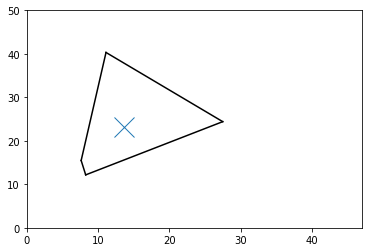

In [80]:
plotHull(hull,points)

In [75]:
reverse_moment[indexBallCaught][5][]

False

In [1]:
isInHull(hull,points,80,30)

NameError: name 'isInHull' is not defined

In [23]:
data['events'][164]["moments"]

[]